## This notebook has two major sections. The first loads in the large, combined dataset and outputs monthly files.

## The second loads in these monthly files and performs instrument calculations and aggregations.

# Begin Splitting

In [1]:
import findspark
findspark.init()

In [427]:
import pyspark
import pandas as pd 
import numpy as np
import os 
import datetime
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.window import Window
from math import radians, cos, sin, asin, sqrt
from pyspark.sql import functions as F
from pyspark.sql.functions import col, row_number, round, substring, count, when, isnan, min, max, avg, stddev_samp, abs, sum, count
from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

from datetime import date, timedelta

import datetime

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

pd.set_option('display.max_columns', None)

In [3]:
spark = SparkSession.builder.master("local[*]").config("spark.executor.memory", "48g").config("spark.driver.memory", "48g").config("spark.driver.maxResultSize","0").getOrCreate()

In [5]:
gdrive_path = 'I:\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data\\'
local_path = 'C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\data\\'

In [7]:
wind_grid_points = spark.read.option("header",True).csv(os.path.join(local_path,'all_wind_measurements.csv'))

In [8]:
wind_grid_points = wind_grid_points.withColumnRenamed('lat','wind_lat').withColumnRenamed('lon','wind_lon')

In [9]:
used_grid_points = spark.read.option("header",True).csv(os.path.join(local_path,'all_used_wind_sites.csv'))

In [10]:
used_grid_points.limit(5).show()

+----------+---------+-----------+
|grid_index| wind_lat|   wind_lon|
+----------+---------+-----------+
|       443|37.779999|-122.160004|
|       722|34.529999|-120.410004|
|       631|38.279999|-120.910004|
|       589|39.279999|-121.160004|
|      1105|33.779999|-117.910004|
+----------+---------+-----------+



In [11]:
used_grid_points.printSchema()

root
 |-- grid_index: string (nullable = true)
 |-- wind_lat: string (nullable = true)
 |-- wind_lon: string (nullable = true)



In [12]:
used_grid_points = used_grid_points.withColumn("wind_lat",used_grid_points.wind_lat.cast('double'))
used_grid_points = used_grid_points.withColumn("wind_lon",used_grid_points.wind_lon.cast('double'))

In [16]:
wind_grid_points = wind_grid_points.withColumn("wind_lat",wind_grid_points.wind_lat.cast('double'))
wind_grid_points = wind_grid_points.withColumn("wind_lon",wind_grid_points.wind_lon.cast('double'))
wind_grid_points = wind_grid_points.withColumn("u",wind_grid_points.u.cast('double'))
wind_grid_points = wind_grid_points.withColumn("v",wind_grid_points.v.cast('double'))
wind_grid_points = wind_grid_points.withColumn("wdir",wind_grid_points.wdir.cast('double'))
wind_grid_points = wind_grid_points.withColumn("wspd",wind_grid_points.wspd.cast('double'))
wind_grid_points = wind_grid_points.drop('_c0')

In [22]:
wind_grid_points = wind_grid_points.withColumn("wind_lat",round(col('wind_lat'),6))
wind_grid_points = wind_grid_points.withColumn("wind_lon",round(col('wind_lon'),6))
wind_grid_points = wind_grid_points.withColumn("u",round(col('u'),6))
wind_grid_points = wind_grid_points.withColumn("v",round(col('v'),6))
wind_grid_points = wind_grid_points.withColumn("wdir",round(col('wdir'),6))
wind_grid_points = wind_grid_points.withColumn("wspd",round(col('wspd'),6))

In [23]:
wind_grid_points.limit(5).show()

+---------+-----------+--------+---------+----------+--------+-------------------+
| wind_lat|   wind_lon|       u|        v|      wdir|    wspd|           Datetime|
+---------+-----------+--------+---------+----------+--------+-------------------+
|42.279999|-124.410004|1.316132| -4.17089|287.513185|4.373617|2001-01-01 00:00:00|
|42.029999|-124.410004|1.720276|-4.124691|292.639445|4.469052|2001-01-01 00:00:00|
|41.779999|-124.410004|2.337209|-4.626282| 296.80302|5.183149|2001-01-01 00:00:00|
|41.529999|-124.410004|2.451185|-5.043875|295.918485|5.607939|2001-01-01 00:00:00|
|41.279999|-124.410004| 2.09671|-5.050475|292.545832|5.468408|2001-01-01 00:00:00|
+---------+-----------+--------+---------+----------+--------+-------------------+



In [17]:
wind_grid_points.printSchema()

root
 |-- wind_lat: double (nullable = true)
 |-- wind_lon: double (nullable = true)
 |-- u: double (nullable = true)
 |-- v: double (nullable = true)
 |-- wdir: double (nullable = true)
 |-- wspd: double (nullable = true)
 |-- Datetime: string (nullable = true)



## Use inner join to filter out unused points

In [24]:
used_wind_observations = wind_grid_points.join(used_grid_points, ['wind_lat','wind_lon'], how='inner')

In [25]:
used_wind_observations.count()

71825712

### Pre-compute min-max for scaled version of instrument below

In [99]:
min_wspd = used_wind_observations.select(min('wspd')).collect()
max_wspd = used_wind_observations.select(max('wspd')).collect()

print("Max wspd is ",max_wspd,"; min wspd is",min_wspd,".",sep="")

Max wspd is [Row(max(wspd)=19.395623)]; min wspd is[Row(min(wspd)=0.000415)].


In [103]:
min_wspd = min_wspd[0][0]
max_wspd = max_wspd[0][0]

TypeError: 'float' object is not subscriptable

In [104]:
print("Max wspd is ",max_wspd,"; min wspd is ",min_wspd,".",sep="")

Max wspd is 19.395623; min wspd is 0.000415.


   ## Save off subset

In [26]:
used_wind_observations.write.parquet(os.path.join(local_path,'wind_subset'))

## Start splitting out --

In [57]:
# create by-month data structure

month_bins_pd = pd.date_range(start='2000-12-01',end='2017-12-01',freq='m')

month_bins = []

for month in month_bins_pd:
    month_bins.append(datetime.datetime.strftime(month+timedelta(days=1), "%Y-%m"))

print(month_bins)

['2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', '2001-12', '2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08', '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-06', '2003-07', '2003-08', '2003-09', '2003-10', '2003-11', '2003-12', '2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', '2004-08', '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02', '2005-03', '2005-04', '2005-05', '2005-06', '2005-07', '2005-08', '2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02', '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', '2006-08', '2006-09', '2006-10', '2006-11', '2006-12', '2007-01', '2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09', '2007-10', '2007-11', '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07'

In [60]:
# create compare column

used_wind_observations = used_wind_observations.withColumn('y-m', substring('Datetime', 1,7))

In [61]:
used_wind_observations.limit(25).show()

+---------+-----------+---------+---------+----------+--------+-------------------+----------+-------+
| wind_lat|   wind_lon|        u|        v|      wdir|    wspd|           Datetime|grid_index|    y-m|
+---------+-----------+---------+---------+----------+--------+-------------------+----------+-------+
|42.029999|-124.160004| 0.170099| -1.91193|275.084065|1.919482|2001-01-01 00:00:00|        44|2001-01|
|41.779999|-124.160004| 0.610318|-2.619918|283.113362|2.690066|2001-01-01 00:00:00|       123|2001-01|
|41.529999|-124.160004| 0.897872|-3.260106|285.398186|3.381489|2001-01-01 00:00:00|       124|2001-01|
|41.279999|-124.160004| 0.849772|-3.431103| 283.91038|3.534768|2001-01-01 00:00:00|       125|2001-01|
|41.029999|-124.160004| 0.826245|-3.327305|283.945749|3.428358|2001-01-01 00:00:00|       126|2001-01|
|40.779999|-124.160004| 0.781805|-3.174908|283.833566|3.269749|2001-01-01 00:00:00|       127|2001-01|
|40.529999|-124.160004| 0.707041|-2.862313|283.875283|2.948346|2001-01-01

In [75]:
# Check for nulls

used_wind_observations.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in used_wind_observations.columns]).show()

+--------+--------+---+---+----+----+--------+----------+---+
|wind_lat|wind_lon|  u|  v|wdir|wspd|Datetime|grid_index|y-m|
+--------+--------+---+---+----+----+--------+----------+---+
|       0|       0|  0|  0|   0|   0|       0|         0|  0|
+--------+--------+---+---+----+----+--------+----------+---+



In [84]:
# Check for large values

used_wind_observations.select([count(when((col(c).cast('integer') > 360), c)).alias(c) for c in used_wind_observations.columns]).show()

+--------+--------+---+---+----+----+--------+----------+---+
|wind_lat|wind_lon|  u|  v|wdir|wspd|Datetime|grid_index|y-m|
+--------+--------+---+---+----+----+--------+----------+---+
|       0|       0|  0|  0|   0|   0|       0|  62139672|  0|
+--------+--------+---+---+----+----+--------+----------+---+



In [91]:
# Check for zeros (are all of these valid??)

used_wind_observations.select([count(when((col(c).cast('float') == 0), c)).alias(c) for c in used_wind_observations.columns]).show()

+--------+--------+---+---+----+----+--------+----------+---+
|wind_lat|wind_lon|  u|  v|wdir|wspd|Datetime|grid_index|y-m|
+--------+--------+---+---+----+----+--------+----------+---+
|       0|       0|  0|  0|   0|   0|       0|         0|  0|
+--------+--------+---+---+----+----+--------+----------+---+



In [92]:
print("U columns with 0 values:",used_wind_observations.filter(col('u') == 0).count())
print("V columns with 0 values:",used_wind_observations.filter(col('v') == 0).count())

U columns with 0 values: 0
V columns with 0 values: 0


In [90]:
# Check for u and v being 0

used_wind_observations.filter((col('u') + col('v')) == 0).count()

14

In [64]:
# create and write out dataframe for each month

for ym in month_bins:
    
    print("Now working on",ym,"subset.")
    
    file_name = os.path.join(local_path,'wind_subset_by_month\\', ym)
    
    temp_df = used_wind_observations.filter(col("y-m") == ym)
    
    print("Total observations for ",ym,": ",temp_df.count(),".",sep="")
    print("Now writing")
    
    temp_df.write.parquet(file_name)

Now working on 2001-01 subset.
Total observations for 2001-01: 358608.
Now writing
Now working on 2001-02 subset.
Total observations for 2001-02: 323904.
Now writing
Now working on 2001-03 subset.
Total observations for 2001-03: 358608.
Now writing
Now working on 2001-04 subset.
Total observations for 2001-04: 347040.
Now writing
Now working on 2001-05 subset.
Total observations for 2001-05: 358608.
Now writing
Now working on 2001-06 subset.
Total observations for 2001-06: 347040.
Now writing
Now working on 2001-07 subset.
Total observations for 2001-07: 358608.
Now writing
Now working on 2001-08 subset.
Total observations for 2001-08: 358608.
Now writing
Now working on 2001-09 subset.
Total observations for 2001-09: 347040.
Now writing
Now working on 2001-10 subset.
Total observations for 2001-10: 358608.
Now writing
Now working on 2001-11 subset.
Total observations for 2001-11: 347040.
Now writing
Now working on 2001-12 subset.
Total observations for 2001-12: 358608.
Now writing
Now 

Now working on 2009-04 subset.
Total observations for 2009-04: 347040.
Now writing
Now working on 2009-05 subset.
Total observations for 2009-05: 358608.
Now writing
Now working on 2009-06 subset.
Total observations for 2009-06: 347040.
Now writing
Now working on 2009-07 subset.
Total observations for 2009-07: 358608.
Now writing
Now working on 2009-08 subset.
Total observations for 2009-08: 358608.
Now writing
Now working on 2009-09 subset.
Total observations for 2009-09: 347040.
Now writing
Now working on 2009-10 subset.
Total observations for 2009-10: 358608.
Now writing
Now working on 2009-11 subset.
Total observations for 2009-11: 347040.
Now writing
Now working on 2009-12 subset.
Total observations for 2009-12: 358608.
Now writing
Now working on 2010-01 subset.
Total observations for 2010-01: 358608.
Now writing
Now working on 2010-02 subset.
Total observations for 2010-02: 323904.
Now writing
Now working on 2010-03 subset.
Total observations for 2010-03: 358608.
Now writing
Now 

Now working on 2017-07 subset.
Total observations for 2017-07: 358608.
Now writing
Now working on 2017-08 subset.
Total observations for 2017-08: 358608.
Now writing
Now working on 2017-09 subset.
Total observations for 2017-09: 347040.
Now writing
Now working on 2017-10 subset.
Total observations for 2017-10: 358608.
Now writing
Now working on 2017-11 subset.
Total observations for 2017-11: 347040.
Now writing
Now working on 2017-12 subset.
Total observations for 2017-12: 358608.
Now writing


# End Splitting

___________________


# Begin Calculations/Aggregation Step-through
## If you want to just run this, go down to Begin Calculation/Aggregation Loop

## Load in lookup tables and data sources

## Quick overview

### Pre-compute scalars for distance and TPY norming:
#### Load in `school_year_to_point_lookup_top_5_filtered`, select point_source_index, point_source_pm25_tpy,school_to_ps_geod_dist_m
#### Calculate avg, stddev_samp, max, min (AFTER standard scaling)
#### Save as scalars (outside of loop)

### Make list to hold Pandas dataframes of aggregated instruments

## Start loop

### initialize empty Pandas dataframe

### Load in month of wind data
### Temporarily store backup of wind readings for self-joining (remove lat/lon/y-m) (temp_wind_readings_df)
### Temporarily store simple averages of wdir/wspd per zip code (to Pandas?) (temp_df_avgs_by_zip)

--- wind_temp_df

## Perform joins:

### First join: inner: wind points to schools from pre-computed lookup (school_lookup)

---compute zip code avgs, save off

--add column for current year
join year lookup for ps
drop column for current year

### Second itty-bitty join: measurement year to ps_lookup year to avoid duplicates

### third join: left: schools to top five point sources from pre-computed lookup (school_to_ps_lookup)
--join on CDSCode and lookup_year

### fourth join: left: point sources to associated wind grid points from pre-computed lookup (ps_lookup)
### Fifth join: left: point source wind grid indices to wind measurements at the same time marker (wind_temp_df)
join on grid_index and Datetime
renamed u, v, wspd, wdir_wrt_0N

### Compute Θd for each row (wind_alignment)
#### **Be sure to subtract the raw value from 180 so that high values indicate good alignment**

### Add columns for normed TPY and Dps (ps_pm25_tpy_normed, school_to_ps_geod_dist_m_normed)

((X - Xmin) / (Xmax - Xmin))

min_wspd
max_wspd
ps_TPY_mean
ps_dist_mean
ps_TPY_sd
ps_dist_sd
ps_TPY_min
ps_dist_min
ps_TPY_max
ps_dist_max


### Add columns for normed Θd and wspd for v5 (wind_alignment_normed, wspd_normed)

### Compute each instrument for each row:
#### Izmd_v1_unnormed
#### Izmd_v2_nodist_unnormed
#### Izmd_v3_normed_D_and_TPY
#### Izmd_v4_nodist_normed_TPY
#### Izmd_v5_all_normed

### Save off completely un-aggregated version (wind_subset_by_month_joined_unaggregated / yyyy-mm)

### Aggregate to CDSCode level, summing each instrument

### Aggregate at school zip code, averaging each instrument 

### Rejoin with simple avgs

### Save off version aggregated at school level (aggregated_inst_by_month / yyyy-mm)

### Convert aggregated version to Pandas df and append to list

## End loop

### Append list of aggregated instruments into single dataframe and save off

## Below, we will walk through a single example month to check the code.
## After that, we will define the loop to run through all months and run it.

In [455]:
# load files

local_dir = 'C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\data\\'

school_lookup = spark.read.option("header",True).csv(os.path.join(local_dir, 'wind_grid_to_school_lookup_filtered.csv'))
ps_year_lookup = spark.read.option("header",True).csv(os.path.join(local_dir, 'year_lookup.csv'))
school_to_ps_lookup = spark.read.option("header",True).csv(os.path.join(local_dir, 'school_year_to_point_lookup_top_5_filtered.csv'))
ps_lookup = spark.read.option("header",True).csv(os.path.join(local_dir, 'wind_grid_to_ps_point_lookup_filtered.csv'))
school_filter = spark.read.option("header",True).csv(os.path.join(local_dir,'school_ym_filter.csv'))

In [164]:
school_lookup.limit(5).show()

+-----------------+--------------+----------+----------+-----------+--------------------------+
|school_grid_index|       CDSCode|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|
+-----------------+--------------+----------+----------+-----------+--------------------------+
|              789|10101080119628|     93706| 36.730273|-119.807915|               10656.24466|
|              866|10621096005839|     93631| 36.554793|-119.504582|               8904.455363|
|              827|10621176109920|     93720| 36.875241|-119.759962|               13828.73923|
|              827|10621176116313|     93611|   36.8173|-119.674236|                4329.91988|
|              753|10621251030477|     93234| 36.208894|-120.098567|               9630.587612|
+-----------------+--------------+----------+----------+-----------+--------------------------+



In [165]:
school_to_ps_lookup.limit(5).show()

+--------------+--------+-----------------+---------------------+----------------+------------------------+---------------+----------------+
|       CDSCode|ps_index|point_source_year|point_source_pm25_tpy|point_source_zip|school_to_ps_geod_dist_m|angle_to_school|ps_distance_rank|
+--------------+--------+-----------------+---------------------+----------------+------------------------+---------------+----------------+
|10621171030071|     111|             2002|           2.30478261|           93612|             710.4600631|   -53.65448057|               1|
|10621171030071|     624|             2002|               10.089|           93727|              6602.12932|    -1.83659538|               2|
|10621171030071|     787|             2002|              29.2146|           93711|             11296.27967|    100.0364033|               3|
|10621171030071|      95|             2002|          2.230020551|           93721|             14026.48193|    32.45898722|               4|
|106211710300

In [166]:
ps_lookup.limit(5).show()

+-------------+--------+----------------------+
|ps_grid_index|ps_index|wind_to_ps_geod_dist_m|
+-------------+--------+----------------------+
|          443|    1019|           9658.554153|
|          722|    1097|           8926.231706|
|          631|     110|           11822.85566|
|          589|    1103|           13572.37684|
|         1105|     124|           15949.34107|
+-------------+--------+----------------------+



In [456]:
# TPY/dist stats part 1

cols_to_drop = ['point_source_index','CDSCode', 'point_source_year', 'point_source_zip', 'angle_to_school', 'ps_distance_rank']

ps_agg = school_to_ps_lookup.drop(*cols_to_drop).distinct().cache()

ps_agg.limit(5).show()

+--------+---------+-----------+-------+-----------+------+------------------------+
|ps_index|   ps_lat|     ps_lon|ps_year|ps_pm25_tpy|ps_zip|school_to_ps_geod_dist_m|
+--------+---------+-----------+-------+-----------+------+------------------------+
|    2885| 36.90345| -119.75703|   2008| 9.64825383| 93730|             6462.600748|
|    2674|33.790827|-118.229607|   2008|4.684987571| 90744|             3323.244242|
|    2713|33.957819|-118.191938|   2008|   5.425192| 90280|             2446.774931|
|    4933| 36.98572| -120.11198|   2014|  2.4149127| 93637|              38425.2545|
|    2152| 38.72779| -121.31947|   2008|  1.8022843| 95747|             12671.59479|
+--------+---------+-----------+-------+-----------+------+------------------------+



In [113]:
# TPY/dist stats part 2
# compute mean/sd scalars

ps_stats = ps_agg.select(avg('point_source_pm25_tpy'), avg('school_to_ps_geod_dist_m'), 
                         stddev_samp('point_source_pm25_tpy'), stddev_samp('school_to_ps_geod_dist_m')).collect()

ps_stats

ps_stats = ps_stats[0]

print(ps_stats)

Row(avg(point_source_pm25_tpy)=13.225952014379654, avg(school_to_ps_geod_dist_m)=10453.018640947166, stddev_samp(point_source_pm25_tpy)=50.486910084637685, stddev_samp(school_to_ps_geod_dist_m)=13818.527648504192)


In [114]:
# TPY/dist stats part 3
# save out scalars for mean/sd

ps_TPY_mean = ps_stats[0]
ps_dist_mean = ps_stats[1]
ps_TPY_sd = ps_stats[2]
ps_dist_sd = ps_stats[3]

print("avg tpy:", ps_TPY_mean)

avg tpy: 13.225952014379654


In [116]:
# TPY/dist stats part 4
# use scalars to scale values

ps_agg = ps_agg.withColumn('TPY_norm', (col('point_source_pm25_tpy') - ps_TPY_mean)/ps_TPY_sd).withColumn('dist_norm', (col('school_to_ps_geod_dist_m') - ps_dist_mean)/ps_dist_sd)

ps_stats_mm = ps_agg.select(min('TPY_norm'), min('dist_norm'), max('TPY_norm'), max('dist_norm')).collect()

ps_stats_mm = ps_stats_mm[0]

print(ps_stats_mm)

Row(min(TPY_norm)=-0.2464301038332982, min(dist_norm)=-0.7541348842439959, max(TPY_norm)=61.78923457101895, max(dist_norm)=12.084924082134723)


In [118]:
# TPY/dist stats part 3
# save out scalars for min/max

ps_TPY_min = ps_stats_mm[0]
ps_dist_min = ps_stats_mm[1]
ps_TPY_max = ps_stats_mm[2]
ps_dist_max = ps_stats_mm[3]

print("min_norm_tpy:", ps_TPY_min)

min_norm_tpy: -0.2464301038332982


## Data structures (testing)

In [458]:
# testing only
parquet_file = '2001-01'

zmy_agg_list = []
school_my_agg_list = []
df_avgs_list = []

In [459]:
in_dir = 'C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\data\\wind_subset_by_month\\'

out_dir_unagged = 'C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\data\\raw_my_spark_dfs'
out_dir_zmy = 'C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\data\\zmy_agged_dfs\\'
out_dir_school_my = 'C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\data\\school_my_agged_dfs\\'

for parquet_file in os.listdir(in_dir):
    
    if parquet_file == '2001-01':
    
        # for holding augmented df at the zip code level
        temp_zmy_df = pd.DataFrame()
        
        # for holding augmented df at the school level
        temp_school_my_df = pd.DataFrame()

        # for holding summmary statistics
        temp_df_avgs = pd.DataFrame()

        # read in one month
        temp_meas_df = spark.read.parquet(os.path.join(in_dir, parquet_file))

In [460]:
temp_meas_df.limit(5).show()

+---------+-----------+--------+---------+----------+--------+-------------------+----------+-------+
| wind_lat|   wind_lon|       u|        v|      wdir|    wspd|           Datetime|grid_index|    y-m|
+---------+-----------+--------+---------+----------+--------+-------------------+----------+-------+
|42.029999|-124.160004|0.170099| -1.91193|275.084065|1.919482|2001-01-01 00:00:00|        44|2001-01|
|41.779999|-124.160004|0.610318|-2.619918|283.113362|2.690066|2001-01-01 00:00:00|       123|2001-01|
|41.529999|-124.160004|0.897872|-3.260106|285.398186|3.381489|2001-01-01 00:00:00|       124|2001-01|
|41.279999|-124.160004|0.849772|-3.431103| 283.91038|3.534768|2001-01-01 00:00:00|       125|2001-01|
|41.029999|-124.160004|0.826245|-3.327305|283.945749|3.428358|2001-01-01 00:00:00|       126|2001-01|
+---------+-----------+--------+---------+----------+--------+-------------------+----------+-------+



In [461]:
# compute wind dir wrt 0N

temp_meas_df = temp_meas_df.withColumn('wdir_wrt_0N',(180*F.atan2(col('u'), col('v'))/(3.141592653589793238462)).cast('double'))

In [462]:
# drop lat/lon, wdir, and y-m and store temp df to re-join for ps wind readings (dropped can be recovered if needed)
# this assumes wdir calc is correct--that is verified below but these were run out of order

wind_temp_df = temp_meas_df.drop('wind_lat','wind_lon','wdir','y-m')

wind_temp_df.cache()

wind_temp_df.limit(10).show()

+---------+---------+--------+-------------------+----------+-------------------+
|        u|        v|    wspd|           Datetime|grid_index|        wdir_wrt_0N|
+---------+---------+--------+-------------------+----------+-------------------+
| 0.170099| -1.91193|1.919482|2001-01-01 00:00:00|        44| 174.91594219384388|
| 0.610318|-2.619918|2.690066|2001-01-01 00:00:00|       123| 166.88664073725573|
| 0.897872|-3.260106|3.381489|2001-01-01 00:00:00|       124| 164.60181000653935|
| 0.849772|-3.431103|3.534768|2001-01-01 00:00:00|       125| 166.08961753606766|
| 0.826245|-3.327305|3.428358|2001-01-01 00:00:00|       126| 166.05424716779632|
| 0.781805|-3.174908|3.269749|2001-01-01 00:00:00|       127| 166.16642852745528|
| 0.707041|-2.862313|2.948346|2001-01-01 00:00:00|       128|  166.1247092524355|
| 1.005051|-3.470103|3.612719|2001-01-01 00:00:00|       129| 163.84732058815214|
|-0.543557|-1.178743|1.298033|2001-01-01 00:00:00|       161|-155.24402584649116|
|-0.377821|-1.73

In [463]:
# rename for explicitness of measurements

temp_meas_df = (temp_meas_df
                .withColumnRenamed('wind_lat','school_wind_lat')
                .withColumnRenamed('wind_lon','school_wind_lon')
                .withColumnRenamed('u','school_u')
                .withColumnRenamed('v','school_v')
                .withColumnRenamed('grid_index','school_grid_index')
               ).drop('wdir') # wdir is wrt 0° E and is confusing; y-m not needed

In [464]:
# spot check calculations (run out of order but this checks the wind dir calc above)
temp_meas_df.limit(25).show()

+---------------+---------------+---------+---------+--------+-------------------+-----------------+-------+-------------------+
|school_wind_lat|school_wind_lon| school_u| school_v|    wspd|           Datetime|school_grid_index|    y-m|        wdir_wrt_0N|
+---------------+---------------+---------+---------+--------+-------------------+-----------------+-------+-------------------+
|      42.029999|    -124.160004| 0.170099| -1.91193|1.919482|2001-01-01 00:00:00|               44|2001-01| 174.91594219384388|
|      41.779999|    -124.160004| 0.610318|-2.619918|2.690066|2001-01-01 00:00:00|              123|2001-01| 166.88664073725573|
|      41.529999|    -124.160004| 0.897872|-3.260106|3.381489|2001-01-01 00:00:00|              124|2001-01| 164.60181000653935|
|      41.279999|    -124.160004| 0.849772|-3.431103|3.534768|2001-01-01 00:00:00|              125|2001-01| 166.08961753606766|
|      41.029999|    -124.160004| 0.826245|-3.327305|3.428358|2001-01-01 00:00:00|              1

In [465]:
temp_meas_df.count()

358608

In [495]:
combined_df = temp_meas_df.join(school_lookup, ['school_grid_index'], how='inner')

In [496]:
combined_df.limit(5).show()

combined_df.count()

+-----------------+---------------+---------------+--------+---------+--------+-------------------+-------+------------------+-------------+----------+----------+-----------+--------------------------+
|school_grid_index|school_wind_lat|school_wind_lon|school_u| school_v|    wspd|           Datetime|    y-m|       wdir_wrt_0N|      CDSCode|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|
+-----------------+---------------+---------------+--------+---------+--------+-------------------+-------+------------------+-------------+----------+----------+-----------+--------------------------+
|               44|      42.029999|    -124.160004|0.170099| -1.91193|1.919482|2001-01-01 00:00:00|2001-01|174.91594219384388|8618206005458|     95567| 41.927578| -124.15199|               11395.56698|
|              123|      41.779999|    -124.160004|0.610318|-2.619918|2.690066|2001-01-01 00:00:00|2001-01|166.88664073725573|8618206005391|     95531| 41.755659|-124.206615|               472

9892968

In [497]:
# filter out schools which were closed, etc--as discovered elsewhere in pipeline
school_filter = school_filter.drop('_c0').withColumnRenamed('cdscode','CDSCode')

# drop join column y-m; it is not needed
combined_df = combined_df.join(school_filter, ['CDSCode','y-m'], how='inner').drop('y-m')

In [498]:
combined_df.limit(5).show()

combined_df.count()

+--------------+-----------------+---------------+---------------+---------+---------+--------+-------------------+-------------------+----------+----------+-----------+--------------------------+
|       CDSCode|school_grid_index|school_wind_lat|school_wind_lon| school_u| school_v|    wspd|           Datetime|        wdir_wrt_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|
+--------------+-----------------+---------------+---------------+---------+---------+--------+-------------------+-------------------+----------+----------+-----------+--------------------------+
|10621176005904|              827|      36.779999|    -119.660004| 1.478731|-0.845149|1.703209|2001-01-01 00:00:00| 119.74955034130205|     93612| 36.814847|-119.703312|               5467.587759|
|10621176005904|              827|      36.779999|    -119.660004| 1.615188|-1.308341|2.078602|2001-01-01 01:00:00| 129.00830191243978|     93612| 36.814847|-119.703312|               5467.587759|
|10621176005904

6704184

In [499]:
# spot check for nulls

combined_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in combined_df.columns]).show()

+-------+-----------------+---------------+---------------+--------+--------+----+--------+-----------+----------+----------+----------+--------------------------+
|CDSCode|school_grid_index|school_wind_lat|school_wind_lon|school_u|school_v|wspd|Datetime|wdir_wrt_0N|school_zip|school_lat|school_lon|wind_to_school_geod_dist_m|
+-------+-----------------+---------------+---------------+--------+--------+----+--------+-----------+----------+----------+----------+--------------------------+
|      0|                0|              0|              0|       0|       0|   0|       0|          0|         0|         0|         0|                         0|
+-------+-----------------+---------------+---------------+--------+--------+----+--------+-----------+----------+----------+----------+--------------------------+



In [500]:
# compute zip code averages for wdir, wspd

zip_avgs = (combined_df.groupBy('school_zip')
            .avg('wspd','wdir_wrt_0N', 'school_u','school_v')
            .withColumnRenamed("school_zip","zip_code")
            .withColumnRenamed("avg(wspd)","avg_wspd_at_school")
            .withColumnRenamed("avg(wdir_wrt_0N)","avg_wdir_0N")
            .withColumnRenamed("avg(school_u)","avg_u")
            .withColumnRenamed("avg(school_v)","avg_v")
            .toPandas()
           )

zip_avgs['y-m'] = parquet_file

display(zip_avgs)

df_avgs_list.append(temp_df_avgs)

,zip_code,avg_wspd_at_school,avg_wdir_0N,avg_u,avg_v,y-m
0,91910,2.616727,-2.110364,0.156748,-0.378105,2017-12
1,92027,1.787543,-26.541009,-0.249706,0.063381,2017-12
2,93450,1.896387,-42.428058,-0.387293,-0.170559,2017-12
3,93013,1.940763,-28.054886,0.038671,-0.458093,2017-12
4,92879,1.615685,-44.518868,-0.568318,0.005619,2017-12
...,...,...,...,...,...,...
1358,95006,3.705027,22.822876,0.355557,-0.879218,2017-12
1359,95720,2.678182,-57.539202,-1.659426,0.309281,2017-12
1360,96059,2.604784,-65.429912,-1.661736,0.082171,2017-12
1361,94956,4.064473,10.049878,-0.040667,-0.277412,2017-12


In [501]:
combined_df = (combined_df
               .withColumnRenamed('wspd','school_wspd')
               .withColumnRenamed('wdir_wrt_0N','school_wdir_0N') 
              )

combined_df.limit(5).show()

+--------------+-----------------+---------------+---------------+---------+---------+-----------+-------------------+-------------------+----------+----------+-----------+--------------------------+
|       CDSCode|school_grid_index|school_wind_lat|school_wind_lon| school_u| school_v|school_wspd|           Datetime|     school_wdir_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|
+--------------+-----------------+---------------+---------------+---------+---------+-----------+-------------------+-------------------+----------+----------+-----------+--------------------------+
|10621176005904|              827|      36.779999|    -119.660004| 1.478731|-0.845149|   1.703209|2001-01-01 00:00:00| 119.74955034130205|     93612| 36.814847|-119.703312|               5467.587759|
|10621176005904|              827|      36.779999|    -119.660004| 1.615188|-1.308341|   2.078602|2001-01-01 01:00:00| 129.00830191243978|     93612| 36.814847|-119.703312|               5467.587759|


In [502]:
combined_df.count()

6704184

In [503]:
combined_df.printSchema()

root
 |-- CDSCode: string (nullable = true)
 |-- school_grid_index: string (nullable = true)
 |-- school_wind_lat: double (nullable = true)
 |-- school_wind_lon: double (nullable = true)
 |-- school_u: double (nullable = true)
 |-- school_v: double (nullable = true)
 |-- school_wspd: double (nullable = true)
 |-- Datetime: string (nullable = true)
 |-- school_wdir_0N: double (nullable = true)
 |-- school_zip: string (nullable = true)
 |-- school_lat: string (nullable = true)
 |-- school_lon: string (nullable = true)
 |-- wind_to_school_geod_dist_m: string (nullable = true)



In [484]:
combined_df.limit(5).show()

+--------------+-------+-----------------+---------------+---------------+---------+---------+-----------+-------------------+-------------------+----------+----------+-----------+--------------------------+
|       CDSCode|    y-m|school_grid_index|school_wind_lat|school_wind_lon| school_u| school_v|school_wspd|           Datetime|     school_wdir_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|
+--------------+-------+-----------------+---------------+---------------+---------+---------+-----------+-------------------+-------------------+----------+----------+-----------+--------------------------+
|10621176005904|2001-01|              827|      36.779999|    -119.660004| 1.478731|-0.845149|   1.703209|2001-01-01 00:00:00| 119.74955034130205|     93612| 36.814847|-119.703312|               5467.587759|
|10621176005904|2001-01|              827|      36.779999|    -119.660004| 1.615188|-1.308341|   2.078602|2001-01-01 01:00:00| 129.00830191243978|     93612| 36.814847|

In [504]:
# need to lookup by CDSCode and year, so substring for year

combined_df = combined_df.withColumn("year", substring(col('Datetime'),1,4))

combined_df.limit(5).show()

+--------------+-----------------+---------------+---------------+---------+---------+-----------+-------------------+-------------------+----------+----------+-----------+--------------------------+----+
|       CDSCode|school_grid_index|school_wind_lat|school_wind_lon| school_u| school_v|school_wspd|           Datetime|     school_wdir_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|year|
+--------------+-----------------+---------------+---------------+---------+---------+-----------+-------------------+-------------------+----------+----------+-----------+--------------------------+----+
|10621176005904|              827|      36.779999|    -119.660004| 1.478731|-0.845149|   1.703209|2001-01-01 00:00:00| 119.74955034130205|     93612| 36.814847|-119.703312|               5467.587759|2001|
|10621176005904|              827|      36.779999|    -119.660004| 1.615188|-1.308341|   2.078602|2001-01-01 01:00:00| 129.00830191243978|     93612| 36.814847|-119.703312|        

In [505]:
# join in ps <-> year lookup

combined_df = combined_df.join(ps_year_lookup, ['year'], how='left').drop('year')

combined_df.count()

6704184

In [506]:
combined_df.limit(5).show()

+--------------+-----------------+---------------+---------------+---------+---------+-----------+-------------------+-------------------+----------+----------+-----------+--------------------------+-------+
|       CDSCode|school_grid_index|school_wind_lat|school_wind_lon| school_u| school_v|school_wspd|           Datetime|     school_wdir_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|ps_year|
+--------------+-----------------+---------------+---------------+---------+---------+-----------+-------------------+-------------------+----------+----------+-----------+--------------------------+-------+
|10621176005904|              827|      36.779999|    -119.660004| 1.478731|-0.845149|   1.703209|2001-01-01 00:00:00| 119.74955034130205|     93612| 36.814847|-119.703312|               5467.587759|   2002|
|10621176005904|              827|      36.779999|    -119.660004| 1.615188|-1.308341|   2.078602|2001-01-01 01:00:00| 129.00830191243978|     93612| 36.814847|-119.703

In [507]:
combined_df = combined_df.join(school_to_ps_lookup, ['CDSCode','ps_year'], how='left')

In [508]:
combined_df.limit(5).show()

+--------------+-------+-----------------+---------------+---------------+--------+---------+-----------+-------------------+------------------+----------+----------+-----------+--------------------------+--------+------+------+-----------+------+------------------------+---------------+----------------+
|       CDSCode|ps_year|school_grid_index|school_wind_lat|school_wind_lon|school_u| school_v|school_wspd|           Datetime|    school_wdir_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|ps_index|ps_lat|ps_lon|ps_pm25_tpy|ps_zip|school_to_ps_geod_dist_m|angle_to_school|ps_distance_rank|
+--------------+-------+-----------------+---------------+---------------+--------+---------+-----------+-------------------+------------------+----------+----------+-----------+--------------------------+--------+------+------+-----------+------+------------------------+---------------+----------------+
|10619946005730|   2002|              790|      36.529999|    -119.910004| 0.72168

In [509]:
combined_df.count()

6704184

In [510]:
combined_df = combined_df.join(ps_lookup, ['ps_index'], how='left')

# length should not have changed

combined_df.count()

6704184

In [511]:
combined_df = combined_df.withColumnRenamed('geod_dist_m', 'school_to_ps_geod_dist_m')

In [512]:
combined_df.limit(5).show()

+--------+--------------+-------+-----------------+---------------+---------------+--------+---------+-----------+-------------------+------------------+----------+----------+-----------+--------------------------+------+------+-----------+------+------------------------+---------------+----------------+-------------+----------------------+
|ps_index|       CDSCode|ps_year|school_grid_index|school_wind_lat|school_wind_lon|school_u| school_v|school_wspd|           Datetime|    school_wdir_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|ps_lat|ps_lon|ps_pm25_tpy|ps_zip|school_to_ps_geod_dist_m|angle_to_school|ps_distance_rank|ps_grid_index|wind_to_ps_geod_dist_m|
+--------+--------------+-------+-----------------+---------------+---------------+--------+---------+-----------+-------------------+------------------+----------+----------+-----------+--------------------------+------+------+-----------+------+------------------------+---------------+----------------+---------

In [513]:
combined_df = combined_df.withColumnRenamed("ps_grid_index","grid_index")

In [384]:
# join in saved-off wind measurements

combined_df = combined_df.join(wind_temp_df, ['grid_index',"Datetime"], how='left')

In [385]:
combined_df = (combined_df
                .withColumnRenamed('u','ps_u')
                .withColumnRenamed('v','ps_v')
                .withColumnRenamed('wspd','ps_wspd')
                .withColumnRenamed('wdir_wrt_0N','ps_wdir_0N')
               )

In [386]:
combined_df.count()

49464840

In [387]:
combined_df.limit(5).show()

+----------+-------------------+--------+-------------+-------+-----------------+---------------+---------------+--------+---------+-----------+------------------+----------+----------+-----------+--------------------------+---------+-----------+-----------+------+-----------+---------------+----------------+----------------------+--------+---------+--------+------------------+
|grid_index|           Datetime|ps_index|      CDSCode|ps_year|school_grid_index|school_wind_lat|school_wind_lon|school_u| school_v|school_wspd|    school_wdir_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|   ps_lat|     ps_lon|ps_pm25_tpy|ps_zip|geod_dist_m|angle_to_school|ps_distance_rank|wind_to_ps_geod_dist_m|    ps_u|     ps_v| ps_wspd|        ps_wdir_0N|
+----------+-------------------+--------+-------------+-------+-----------------+---------------+---------------+--------+---------+-----------+------------------+----------+----------+-----------+--------------------------+---------+----

In [388]:
combined_df.printSchema()

root
 |-- grid_index: string (nullable = true)
 |-- Datetime: string (nullable = true)
 |-- ps_index: string (nullable = true)
 |-- CDSCode: string (nullable = true)
 |-- ps_year: string (nullable = true)
 |-- school_grid_index: string (nullable = true)
 |-- school_wind_lat: double (nullable = true)
 |-- school_wind_lon: double (nullable = true)
 |-- school_u: double (nullable = true)
 |-- school_v: double (nullable = true)
 |-- school_wspd: double (nullable = true)
 |-- school_wdir_0N: double (nullable = true)
 |-- school_zip: string (nullable = true)
 |-- school_lat: string (nullable = true)
 |-- school_lon: string (nullable = true)
 |-- wind_to_school_geod_dist_m: string (nullable = true)
 |-- ps_lat: string (nullable = true)
 |-- ps_lon: string (nullable = true)
 |-- ps_pm25_tpy: string (nullable = true)
 |-- ps_zip: string (nullable = true)
 |-- geod_dist_m: string (nullable = true)
 |-- angle_to_school: string (nullable = true)
 |-- ps_distance_rank: string (nullable = true)
 |--

In [389]:
combined_df = combined_df.withColumn("angle_to_school",col("angle_to_school").cast("double"))

In [390]:
combined_df.printSchema()

root
 |-- grid_index: string (nullable = true)
 |-- Datetime: string (nullable = true)
 |-- ps_index: string (nullable = true)
 |-- CDSCode: string (nullable = true)
 |-- ps_year: string (nullable = true)
 |-- school_grid_index: string (nullable = true)
 |-- school_wind_lat: double (nullable = true)
 |-- school_wind_lon: double (nullable = true)
 |-- school_u: double (nullable = true)
 |-- school_v: double (nullable = true)
 |-- school_wspd: double (nullable = true)
 |-- school_wdir_0N: double (nullable = true)
 |-- school_zip: string (nullable = true)
 |-- school_lat: string (nullable = true)
 |-- school_lon: string (nullable = true)
 |-- wind_to_school_geod_dist_m: string (nullable = true)
 |-- ps_lat: string (nullable = true)
 |-- ps_lon: string (nullable = true)
 |-- ps_pm25_tpy: string (nullable = true)
 |-- ps_zip: string (nullable = true)
 |-- geod_dist_m: string (nullable = true)
 |-- angle_to_school: double (nullable = true)
 |-- ps_distance_rank: string (nullable = true)
 |--

In [391]:
# spot check for nulls

combined_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in combined_df.columns]).show()

+----------+--------+--------+-------+-------+-----------------+---------------+---------------+--------+--------+-----------+--------------+----------+----------+----------+--------------------------+------+------+-----------+------+-----------+---------------+----------------+----------------------+----+----+-------+----------+
|grid_index|Datetime|ps_index|CDSCode|ps_year|school_grid_index|school_wind_lat|school_wind_lon|school_u|school_v|school_wspd|school_wdir_0N|school_zip|school_lat|school_lon|wind_to_school_geod_dist_m|ps_lat|ps_lon|ps_pm25_tpy|ps_zip|geod_dist_m|angle_to_school|ps_distance_rank|wind_to_ps_geod_dist_m|ps_u|ps_v|ps_wspd|ps_wdir_0N|
+----------+--------+--------+-------+-------+-----------------+---------------+---------------+--------+--------+-----------+--------------+----------+----------+----------+--------------------------+------+------+-----------+------+-----------+---------------+----------------+----------------------+----+----+-------+----------+
|   

In [392]:
# first angle is wind angle, second angle is heading to school (both wrt 0N)

def calculateDifferenceBetweenAngles(firstAngle, secondAngle):
    difference = secondAngle - firstAngle
    if (difference <= -180): 
        difference += 360
        return difference
    elif (difference >= 180): 
        difference -= 360
        return difference
    return difference

udf_calculateDifferenceBetweenAngles = F.udf(calculateDifferenceBetweenAngles)

In [ ]:


df.withColumn(
    'monthly_spend',
    expr('transform(monthly_spend, x -> CASE WHEN x >= 100 THEN x - (x * 0.10) ELSE x END)'))

In [393]:
combined_df = (combined_df
               .withColumn("school_wind_alignment",
                           udf_calculateDifferenceBetweenAngles(
                           col('school_wdir_0N'), col('angle_to_school')).cast('double'))
               .withColumn("ps_wind_alignment",
                           udf_calculateDifferenceBetweenAngles(
                           col('ps_wdir_0N'), col('angle_to_school')).cast('double'))
              )

In [394]:
combined_df.limit(5).show()

+----------+-------------------+--------+--------------+-------+-----------------+---------------+---------------+---------+---------+-----------+------------------+----------+----------+-----------+--------------------------+---------+-----------+-----------+------+-----------+---------------+----------------+----------------------+--------+---------+--------+-----------------+---------------------+-------------------+
|grid_index|           Datetime|ps_index|       CDSCode|ps_year|school_grid_index|school_wind_lat|school_wind_lon| school_u| school_v|school_wspd|    school_wdir_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|   ps_lat|     ps_lon|ps_pm25_tpy|ps_zip|geod_dist_m|angle_to_school|ps_distance_rank|wind_to_ps_geod_dist_m|    ps_u|     ps_v| ps_wspd|       ps_wdir_0N|school_wind_alignment|  ps_wind_alignment|
+----------+-------------------+--------+--------------+-------+-----------------+---------------+---------------+---------+---------+-----------+------

In [395]:
# spot check for nulls

combined_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in combined_df.columns]).show()

+----------+--------+--------+-------+-------+-----------------+---------------+---------------+--------+--------+-----------+--------------+----------+----------+----------+--------------------------+------+------+-----------+------+-----------+---------------+----------------+----------------------+----+----+-------+----------+---------------------+-----------------+
|grid_index|Datetime|ps_index|CDSCode|ps_year|school_grid_index|school_wind_lat|school_wind_lon|school_u|school_v|school_wspd|school_wdir_0N|school_zip|school_lat|school_lon|wind_to_school_geod_dist_m|ps_lat|ps_lon|ps_pm25_tpy|ps_zip|geod_dist_m|angle_to_school|ps_distance_rank|wind_to_ps_geod_dist_m|ps_u|ps_v|ps_wspd|ps_wdir_0N|school_wind_alignment|ps_wind_alignment|
+----------+--------+--------+-------+-------+-----------------+---------------+---------------+--------+--------+-----------+--------------+----------+----------+----------+--------------------------+------+------+-----------+------+-----------+----------

In [396]:
combined_df = combined_df.withColumn("central_wind_alignment_180_high", 
                                     (180 - abs(((col('school_wind_alignment') + col('ps_wind_alignment'))/2))).cast('double'))

In [397]:
combined_df.limit(5).show()

+----------+-------------------+--------+--------------+-------+-----------------+---------------+---------------+---------+---------+-----------+------------------+----------+----------+-----------+--------------------------+---------+-----------+-----------+------+-----------+---------------+----------------+----------------------+--------+---------+--------+-----------------+---------------------+-------------------+-------------------------------+
|grid_index|           Datetime|ps_index|       CDSCode|ps_year|school_grid_index|school_wind_lat|school_wind_lon| school_u| school_v|school_wspd|    school_wdir_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|   ps_lat|     ps_lon|ps_pm25_tpy|ps_zip|geod_dist_m|angle_to_school|ps_distance_rank|wind_to_ps_geod_dist_m|    ps_u|     ps_v| ps_wspd|       ps_wdir_0N|school_wind_alignment|  ps_wind_alignment|central_wind_alignment_180_high|
+----------+-------------------+--------+--------------+-------+-----------------+------

In [400]:
# compute normed TPY and dist using scalars from above

combined_df = (combined_df
               .withColumn('ps_pm25_tpy_normed', 
                           ((((col('ps_pm25_tpy') - ps_TPY_mean) / ps_TPY_sd) - ps_TPY_min) / (ps_TPY_max - ps_TPY_min)).cast('double'))
               .withColumn('school_to_ps_geod_dist_m_normed',((((col('school_to_ps_geod_dist_m') - ps_dist_mean) / ps_dist_sd) - ps_dist_min) / (ps_dist_max - ps_dist_min)).cast('double'))
              )

In [407]:
# compute normed wspd and wind alignment for Instrument v5

combined_df = (combined_df
               .withColumn('avg_wspd',((col('school_wspd') + col('ps_wspd'))/2).cast('double'))
              )

combined_df = (combined_df
               .withColumn('central_wind_alignment_180_high_normed',
                           (col('central_wind_alignment_180_high')/180).cast('double'))
               .withColumn('avg_wspd_normed',
                           ((col('avg_wspd') - min_wspd) / (max_wspd - min_wspd)).cast('double'))
              )

In [409]:
combined_df.limit(10).show()

+----------+-------------------+--------+--------------+-------+-----------------+---------------+---------------+---------+---------+-----------+-------------------+----------+----------+-----------+--------------------------+---------+-----------+-----------+------+------------------------+---------------+----------------+----------------------+--------+---------+--------+-----------------+---------------------+-------------------+-------------------------------+--------------------+-------------------------------+--------------------------------------+--------------------+-------------------+
|grid_index|           Datetime|ps_index|       CDSCode|ps_year|school_grid_index|school_wind_lat|school_wind_lon| school_u| school_v|school_wspd|     school_wdir_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|   ps_lat|     ps_lon|ps_pm25_tpy|ps_zip|school_to_ps_geod_dist_m|angle_to_school|ps_distance_rank|wind_to_ps_geod_dist_m|    ps_u|     ps_v| ps_wspd|       ps_wdir_0N|sc

In [410]:
combined_df = (combined_df
               .withColumn('Izmd_v1_unnormed',(col('central_wind_alignment_180_high') * col('ps_pm25_tpy') * (col('avg_wspd') / col('school_to_ps_geod_dist_m'))).cast('double'))
               .withColumn('Izmd_v2_nodist_unnormed',(col('central_wind_alignment_180_high') * col('ps_pm25_tpy') * col('avg_wspd')).cast('double'))
               .withColumn('Izmd_v3_normed_D_and_TPY',(col('central_wind_alignment_180_high') * col('ps_pm25_tpy_normed') * (col('avg_wspd') / col('school_to_ps_geod_dist_m_normed'))).cast('double'))
               .withColumn('Izmd_v4_nodist_normed_TPY',(col('central_wind_alignment_180_high') * col('ps_pm25_tpy_normed') * col('avg_wspd')).cast('double'))
               .withColumn('Izmd_v5_all_normed',(col('central_wind_alignment_180_high_normed') * col('ps_pm25_tpy_normed') * (col('avg_wspd_normed') / col('school_to_ps_geod_dist_m_normed'))).cast('double'))
              )

In [411]:
combined_df.limit(10).show()

+----------+-------------------+--------+--------------+-------+-----------------+---------------+---------------+---------+---------+-----------+-------------------+----------+----------+-----------+--------------------------+---------+-----------+-----------+------+------------------------+---------------+----------------+----------------------+--------+---------+--------+-----------------+---------------------+-------------------+-------------------------------+--------------------+-------------------------------+--------------------------------------+--------------------+-------------------+--------------------+-----------------------+------------------------+-------------------------+--------------------+
|grid_index|           Datetime|ps_index|       CDSCode|ps_year|school_grid_index|school_wind_lat|school_wind_lon| school_u| school_v|school_wspd|     school_wdir_0N|school_zip|school_lat| school_lon|wind_to_school_geod_dist_m|   ps_lat|     ps_lon|ps_pm25_tpy|ps_zip|school_to_ps

In [412]:
combined_df.columns

['grid_index',
 'Datetime',
 'ps_index',
 'CDSCode',
 'ps_year',
 'school_grid_index',
 'school_wind_lat',
 'school_wind_lon',
 'school_u',
 'school_v',
 'school_wspd',
 'school_wdir_0N',
 'school_zip',
 'school_lat',
 'school_lon',
 'wind_to_school_geod_dist_m',
 'ps_lat',
 'ps_lon',
 'ps_pm25_tpy',
 'ps_zip',
 'school_to_ps_geod_dist_m',
 'angle_to_school',
 'ps_distance_rank',
 'wind_to_ps_geod_dist_m',
 'ps_u',
 'ps_v',
 'ps_wspd',
 'ps_wdir_0N',
 'school_wind_alignment',
 'ps_wind_alignment',
 'central_wind_alignment_180_high',
 'ps_pm25_tpy_normed',
 'school_to_ps_geod_dist_m_normed',
 'central_wind_alignment_180_high_normed',
 'avg_wspd_normed',
 'avg_wspd',
 'Izmd_v1_unnormed',
 'Izmd_v2_nodist_unnormed',
 'Izmd_v3_normed_D_and_TPY',
 'Izmd_v4_nodist_normed_TPY',
 'Izmd_v5_all_normed']

In [415]:
# start selecting and aggregating down

cols_to_select = ['CDSCode',
                'school_zip',
                'ps_distance_rank',
                'ps_pm25_tpy_normed',
                'ps_pm25_tpy',
                'angle_to_school',
                'school_to_ps_geod_dist_m_normed',
                'school_to_ps_geod_dist_m',
                 'central_wind_alignment_180_high',
                 'central_wind_alignment_180_high_normed',
                 'avg_wspd_normed',
                 'avg_wspd',
                 'Izmd_v1_unnormed',
                 'Izmd_v2_nodist_unnormed',
                 'Izmd_v3_normed_D_and_TPY',
                 'Izmd_v4_nodist_normed_TPY',
                 'Izmd_v5_all_normed']

combined_df = combined_df.select(*cols_to_select)

combined_df.limit(5).show()

+--------------+----------+----------------+--------------------+-----------+---------------+-------------------------------+------------------------+-------------------------------+--------------------------------------+--------------------+------------------+--------------------+-----------------------+------------------------+-------------------------+--------------------+
|       CDSCode|school_zip|ps_distance_rank|  ps_pm25_tpy_normed|ps_pm25_tpy|angle_to_school|school_to_ps_geod_dist_m_normed|school_to_ps_geod_dist_m|central_wind_alignment_180_high|central_wind_alignment_180_high_normed|     avg_wspd_normed|          avg_wspd|    Izmd_v1_unnormed|Izmd_v2_nodist_unnormed|Izmd_v3_normed_D_and_TPY|Izmd_v4_nodist_normed_TPY|  Izmd_v5_all_normed|
+--------------+----------+----------------+--------------------+-----------+---------------+-------------------------------+------------------------+-------------------------------+--------------------------------------+--------------------+

In [417]:
### AGGREGATION 1/3: reduce to m-y-school-ps(-zip) level ###

group_by_cols = ['CDSCode',
                'school_zip',
                'ps_distance_rank',
                'ps_pm25_tpy_normed',
                'ps_pm25_tpy',
                'angle_to_school',
                'school_to_ps_geod_dist_m_normed',
                'school_to_ps_geod_dist_m']

combined_df = combined_df.groupBy(*group_by_cols) \
                .agg(
                avg('central_wind_alignment_180_high').alias('central_wind_alignment_180_high'), \
                avg('central_wind_alignment_180_high_normed').alias('central_wind_alignment_180_high_normed'), \
                avg('avg_wspd_normed').alias('avg_wspd_normed'), \
                avg('avg_wspd').alias('avg_wspd'), \
                sum('Izmd_v1_unnormed').alias('Izmd_v1_unnormed'), \
                sum('Izmd_v2_nodist_unnormed').alias('Izmd_v2_nodist_unnormed'), \
                sum('Izmd_v3_normed_D_and_TPY').alias('Izmd_v3_normed_D_and_TPY'), \
                sum('Izmd_v4_nodist_normed_TPY').alias('Izmd_v4_nodist_normed_TPY'), \
                sum('Izmd_v5_all_normed').alias('Izmd_v5_all_normed') \
                    )

combined_df.limit(10).show()

+--------------+----------+----------------+--------------------+-----------+---------------+-------------------------------+------------------------+-------------------------------+--------------------------------------+-------------------+------------------+------------------+-----------------------+------------------------+-------------------------+------------------+
|       CDSCode|school_zip|ps_distance_rank|  ps_pm25_tpy_normed|ps_pm25_tpy|angle_to_school|school_to_ps_geod_dist_m_normed|school_to_ps_geod_dist_m|central_wind_alignment_180_high|central_wind_alignment_180_high_normed|    avg_wspd_normed|          avg_wspd|  Izmd_v1_unnormed|Izmd_v2_nodist_unnormed|Izmd_v3_normed_D_and_TPY|Izmd_v4_nodist_normed_TPY|Izmd_v5_all_normed|
+--------------+----------+----------------+--------------------+-----------+---------------+-------------------------------+------------------------+-------------------------------+--------------------------------------+-------------------+-----------

In [418]:
combined_df.count()

66485

In [419]:
### AGGREGATION 2/3: reduce to m-y-school(-zip) level ###

combined_df = combined_df.groupBy("CDSCode", "school_zip") \
                .agg(
                avg('central_wind_alignment_180_high').alias('central_wind_alignment_180_high'), \
                avg('ps_pm25_tpy_normed').alias('ps_pm25_tpy_normed'), \
                avg('school_to_ps_geod_dist_m_normed').alias('school_to_ps_geod_dist_m_normed'), \
                avg('ps_pm25_tpy').alias('ps_pm25_tpy'), \
                avg('school_to_ps_geod_dist_m').alias('school_to_ps_geod_dist_m'), \
                avg('central_wind_alignment_180_high_normed').alias('central_wind_alignment_180_high_normed'), \
                avg('avg_wspd_normed').alias('avg_wspd_normed'), \
                avg('avg_wspd').alias('avg_wspd'), \
                sum('Izmd_v1_unnormed').alias('Izmd_v1_unnormed'), \
                sum('Izmd_v2_nodist_unnormed').alias('Izmd_v2_nodist_unnormed'), \
                sum('Izmd_v3_normed_D_and_TPY').alias('Izmd_v3_normed_D_and_TPY'), \
                sum('Izmd_v4_nodist_normed_TPY').alias('Izmd_v4_nodist_normed_TPY'), \
                sum('Izmd_v5_all_normed').alias('Izmd_v5_all_normed') \
                    )

combined_df.limit(10).show()

+--------------+----------+-------------------------------+--------------------+-------------------------------+------------------+------------------------+--------------------------------------+-------------------+------------------+------------------+-----------------------+------------------------+-------------------------+------------------+
|       CDSCode|school_zip|central_wind_alignment_180_high|  ps_pm25_tpy_normed|school_to_ps_geod_dist_m_normed|       ps_pm25_tpy|school_to_ps_geod_dist_m|central_wind_alignment_180_high_normed|    avg_wspd_normed|          avg_wspd|  Izmd_v1_unnormed|Izmd_v2_nodist_unnormed|Izmd_v3_normed_D_and_TPY|Izmd_v4_nodist_normed_TPY|Izmd_v5_all_normed|
+--------------+----------+-------------------------------+--------------------+-------------------------------+------------------+------------------------+--------------------------------------+-------------------+------------------+------------------+-----------------------+------------------------+--

In [420]:
combined_df.count()

13297

In [421]:
### AGGREGATION 3/3: reduce to m-y-zip level ###

combined_df = combined_df.groupBy("school_zip") \
                .agg(
                avg('central_wind_alignment_180_high').alias('central_wind_alignment_180_high'), \
                avg('ps_pm25_tpy_normed').alias('ps_pm25_tpy_normed'), \
                avg('school_to_ps_geod_dist_m_normed').alias('school_to_ps_geod_dist_m_normed'), \
                avg('ps_pm25_tpy').alias('ps_pm25_tpy'), \
                avg('school_to_ps_geod_dist_m').alias('school_to_ps_geod_dist_m'), \
                avg('central_wind_alignment_180_high_normed').alias('central_wind_alignment_180_high_normed'), \
                avg('avg_wspd_normed').alias('avg_wspd_normed'), \
                avg('avg_wspd').alias('avg_wspd'), \
                avg('Izmd_v1_unnormed').alias('Izmd_v1_unnormed'), \
                avg('Izmd_v2_nodist_unnormed').alias('Izmd_v2_nodist_unnormed'), \
                avg('Izmd_v3_normed_D_and_TPY').alias('Izmd_v3_normed_D_and_TPY'), \
                avg('Izmd_v4_nodist_normed_TPY').alias('Izmd_v4_nodist_normed_TPY'), \
                avg('Izmd_v5_all_normed').alias('Izmd_v5_all_normed'), \
                count('CDSCode')
                )

In [422]:
combined_df.limit(10).show()

+----------+-------------------------------+--------------------+-------------------------------+------------------+------------------------+--------------------------------------+-------------------+------------------+------------------+-----------------------+------------------------+-------------------------+------------------+
|school_zip|central_wind_alignment_180_high|  ps_pm25_tpy_normed|school_to_ps_geod_dist_m_normed|       ps_pm25_tpy|school_to_ps_geod_dist_m|central_wind_alignment_180_high_normed|    avg_wspd_normed|          avg_wspd|  Izmd_v1_unnormed|Izmd_v2_nodist_unnormed|Izmd_v3_normed_D_and_TPY|Izmd_v4_nodist_normed_TPY|Izmd_v5_all_normed|
+----------+-------------------------------+--------------------+-------------------------------+------------------+------------------------+--------------------------------------+-------------------+------------------+------------------+-----------------------+------------------------+-------------------------+------------------+
|

In [423]:
combined_df.count()

1539

In [430]:
display(pd_combined_df)

,school_zip,central_wind_alignment_180_high,ps_pm25_tpy_normed,school_to_ps_geod_dist_m_normed,ps_pm25_tpy,school_to_ps_geod_dist_m,central_wind_alignment_180_high_normed,avg_wspd_normed,avg_wspd,Izmd_v1_unnormed,Izmd_v2_nodist_unnormed,Izmd_v3_normed_D_and_TPY,Izmd_v4_nodist_normed_TPY,Izmd_v5_all_normed,y-m
0,93545,83.838107,0.001836,0.285797,6.534494,50737.137513,0.465767,0.073056,1.417343,56.619465,3.092897e+06,2725.352792,881.296346,0.780409,2017-12
1,90022,76.816557,0.001958,0.024536,6.918356,4385.052865,0.426759,0.088330,1.713602,747.958785,3.161758e+06,37474.416083,886.255079,10.731574,2017-12
2,95134,86.754583,0.001530,0.014368,5.576702,2581.073635,0.481970,0.106103,2.058303,1914.158122,3.717731e+06,94362.605192,1018.616360,27.023731,2017-12
3,91910,84.753907,0.011993,0.027924,38.345966,4986.259941,0.470855,0.135873,2.635697,8183.436869,3.248345e+07,459356.513832,10158.477004,131.558119,2017-12
4,95519,106.226910,0.009749,0.069164,31.318293,12302.859938,0.590150,0.183478,3.559006,4756.258363,4.565250e+07,264556.840783,14215.170805,75.771189,2017-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,95595,76.609741,0.007131,0.313867,23.119979,55717.276230,0.425610,0.122226,2.371016,257.009172,1.453019e+07,14059.435628,4478.538944,4.026420,2017-12
1535,95697,95.570250,0.001927,0.034893,6.821147,6222.677918,0.530946,0.126618,2.456203,816.911272,5.200833e+06,40635.870048,1459.008794,11.637578,2017-12
1536,90068,105.093625,0.001554,0.050988,5.651148,9078.079417,0.583853,0.099029,1.921112,503.231207,4.150721e+06,24776.972339,1138.069072,7.095565,2017-12
1537,92285,114.008252,0.017967,0.248821,57.058044,44177.017038,0.633379,0.099679,1.933707,1091.287026,4.455261e+07,61042.581036,14020.187832,17.481067,2017-12


In [424]:
pd_combined_df = combined_df.toPandas()

pd_combined_df['y-m'] = parquet_file

zmy_agg_list.append(combined_df)

NameError: name 'zmy_agg_list' is not defined

In [432]:
pd_combined_df.shape

(1539, 15)

In [434]:
# test final join

df_merged = pd.merge(pd_combined_df, zip_avgs, left_on=["school_zip","y-m"], right_on=["zip_code", "y-m"], how="left")

In [436]:
display(df_merged)

,school_zip,central_wind_alignment_180_high,ps_pm25_tpy_normed,school_to_ps_geod_dist_m_normed,ps_pm25_tpy,school_to_ps_geod_dist_m,central_wind_alignment_180_high_normed,avg_wspd_normed,avg_wspd_x,Izmd_v1_unnormed,Izmd_v2_nodist_unnormed,Izmd_v3_normed_D_and_TPY,Izmd_v4_nodist_normed_TPY,Izmd_v5_all_normed,y-m,zip_code,avg_wspd_y,avg_wdir_0N,avg_u,avg_v
0,93545,83.838107,0.001836,0.285797,6.534494,50737.137513,0.465767,0.073056,1.417343,56.619465,3.092897e+06,2725.352792,881.296346,0.780409,2017-12,93545,1.316469,77.580772,0.943365,-0.255368
1,90022,76.816557,0.001958,0.024536,6.918356,4385.052865,0.426759,0.088330,1.713602,747.958785,3.161758e+06,37474.416083,886.255079,10.731574,2017-12,90022,1.713602,-72.940519,-0.489077,-0.455836
2,95134,86.754583,0.001530,0.014368,5.576702,2581.073635,0.481970,0.106103,2.058303,1914.158122,3.717731e+06,94362.605192,1018.616360,27.023731,2017-12,95134,2.068261,-16.739172,-0.410638,0.179738
3,91910,84.753907,0.011993,0.027924,38.345966,4986.259941,0.470855,0.135873,2.635697,8183.436869,3.248345e+07,459356.513832,10158.477004,131.558119,2017-12,91910,2.654365,0.210515,0.202613,-0.397664
4,95519,106.226910,0.009749,0.069164,31.318293,12302.859938,0.590150,0.183478,3.559006,4756.258363,4.565250e+07,264556.840783,14215.170805,75.771189,2017-12,95519,3.834603,-31.618201,-1.502319,0.392380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,95595,76.609741,0.007131,0.313867,23.119979,55717.276230,0.425610,0.122226,2.371016,257.009172,1.453019e+07,14059.435628,4478.538944,4.026420,2017-12,95595,1.746149,-62.096406,-1.213069,0.062697
1535,95697,95.570250,0.001927,0.034893,6.821147,6222.677918,0.530946,0.126618,2.456203,816.911272,5.200833e+06,40635.870048,1459.008794,11.637578,2017-12,95697,2.438686,54.012624,0.218650,-0.464267
1536,90068,105.093625,0.001554,0.050988,5.651148,9078.079417,0.583853,0.099029,1.921112,503.231207,4.150721e+06,24776.972339,1138.069072,7.095565,2017-12,90068,2.000370,-43.854822,-0.257081,-0.751116
1537,92285,114.008252,0.017967,0.248821,57.058044,44177.017038,0.633379,0.099679,1.933707,1091.287026,4.455261e+07,61042.581036,14020.187832,17.481067,2017-12,92285,2.152793,66.609685,1.068993,-0.526304


## Basic Instrument form (distance is present in some versions only)

## $$I_{zmy} = \sum_{ps=1}^{3} \sum_{d_{m}=1}^{D_{m}}\theta_{downstream_{zd_{m}}} \times TPY_{ps} \times \frac{S_{zd_{m}}}{D_{ps}}$$

V1: as written, no normalizing - Our original IV </br>
V2: no dividing by distance, no normalizing - Cornelia wants this</br>
V3: as written, normalizing - normalize TPY, Dps (z-score, min max)</br>
V4: no dividing by distance, normalizing - normalize TPY, Dps (z-score, min max)</br>
V5: as written, all quantities normed


# End Calculations/Aggregation Step-through

___________________


# Begin Calculation/Aggregation Loop

In [487]:
# Setup directories/variables

local_dir = 'C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\data\\'

out_dir_zmy_raw_avgs = os.path.join(local_dir,'naive_zmy_avgs\\')
out_dir_unagged = os.path.join(local_dir,'raw_my_spark_dfs\\')
out_dir_zmy = os.path.join(local_dir,'zmy_agged_dfs\\')

In [521]:
def aggregate_zmy(early_stopping: int = 0):
    """Process and Aggregate Monthly Data
    Before running this, set input/output directories above.

    This will take a long time and generate many files.
    Its only direct output is a pandas dataframe, but it 
    will save monthly Pandas dataframes to disk in case 
    something needs revisiting.

    Inputs: early_stopping (int): for testing, set to max iterations to perform
    Outputs: combined Pandas dataframe with all aggregated y-m data
    """
    ### Opening Section: Data Load and Preprocessing ###

    # read in files
    school_lookup = spark.read.option("header",True).csv(os.path.join(local_dir, 'wind_grid_to_school_lookup_filtered.csv'))
    ps_year_lookup = spark.read.option("header",True).csv(os.path.join(local_dir, 'year_lookup.csv'))
    school_to_ps_lookup = spark.read.option("header",True).csv(os.path.join(local_dir, 'school_year_to_point_lookup_top_5_filtered.csv'))
    ps_lookup = spark.read.option("header",True).csv(os.path.join(local_dir, 'wind_grid_to_ps_point_lookup_filtered.csv'))
    school_filter = spark.read.option("header",True).csv(os.path.join(local_dir,'school_ym_filter.csv'))
    
    # Calculate and save out statistics for first normalizing (standard scaler)
    cols_to_drop = ['ps_index','CDSCode', 'ps_year', 'ps_zip', 'angle_to_school', 'ps_distance_rank']
    ps_agg = school_to_ps_lookup.drop(*cols_to_drop).distinct().cache()

    ps_stats = ps_agg.select(avg('ps_pm25_tpy'), avg('school_to_ps_geod_dist_m'), 
                             stddev_samp('ps_pm25_tpy'), stddev_samp('school_to_ps_geod_dist_m')).collect()

    ps_stats = ps_stats[0]

    ps_TPY_mean = ps_stats[0]
    ps_dist_mean = ps_stats[1]
    ps_TPY_sd = ps_stats[2]
    ps_dist_sd = ps_stats[3]

    # Calculate and save statistics for second normalizing (min-max)
    ps_agg = ps_agg.withColumn('TPY_norm', (col('ps_pm25_tpy') - ps_TPY_mean)/ps_TPY_sd).withColumn('dist_norm', (col('school_to_ps_geod_dist_m') - ps_dist_mean)/ps_dist_sd)
    ps_stats_mm = ps_agg.select(min('TPY_norm'), min('dist_norm'), max('TPY_norm'), max('dist_norm')).collect()
    ps_stats_mm = ps_stats_mm[0]

    ps_TPY_min = ps_stats_mm[0]
    ps_dist_min = ps_stats_mm[1]
    ps_TPY_max = ps_stats_mm[2]
    ps_dist_max = ps_stats_mm[3]

    # lists to contain pandas dataframes
    zmy_agg_list = []
    df_avgs_list = []
    
    counter = 0

    # loop through files
    for parquet_file in os.listdir(in_dir):
    
        
        if (early_stopping == 0 or counter < early_stopping):
            
            print("Now processing",parquet_file)

            # for holding augmented df at the zip code level
            temp_zmy_df = pd.DataFrame()

            # for holding augmented df at the school level
            temp_school_my_df = pd.DataFrame()

            # read in one month
            temp_meas_df = spark.read.parquet(os.path.join(in_dir, parquet_file))

            temp_meas_df = (temp_meas_df
                            .withColumn('wdir_wrt_0N',(180*F.atan2(col('u'), col('v'))
                                                       /(3.141592653589793238462)).cast('double')
                                       )
                            )

            # drop lat/lon, wdir, and y-m and store temp df to re-join for ps wind readings (dropped can be recovered if needed)
            wind_temp_df = temp_meas_df.drop('wind_lat','wind_lon','wdir','y-m')
            wind_temp_df.cache()

            # rename for explicitness of measurements
            temp_meas_df = (temp_meas_df
                            .withColumnRenamed('wind_lat','school_wind_lat')
                            .withColumnRenamed('wind_lon','school_wind_lon')
                            .withColumnRenamed('u','school_u')
                            .withColumnRenamed('v','school_v')
                            .withColumnRenamed('grid_index','school_grid_index')
                           ).drop('wdir') # wdir is wrt 0° E and is confusing

            combined_df = temp_meas_df.join(school_lookup, ['school_grid_index'], how='inner')

            # filter out schools which were closed, etc--as discovered elsewhere in pipeline
            school_filter = school_filter.drop('_c0').withColumnRenamed('cdscode','CDSCode')

            # drop join column y-m; it is not needed
            combined_df = combined_df.join(school_filter, ['CDSCode','y-m'], how='inner').drop('y-m')
            
            # compute zip code averages for wdir, wspd
            zip_avgs = (combined_df.groupBy('school_zip')
                        .avg('wspd','wdir_wrt_0N', 'school_u','school_v')
                        .withColumnRenamed("school_zip","zip_code")
                        .withColumnRenamed("avg(wspd)","avg_wspd_at_school")
                        .withColumnRenamed("avg(wdir_wrt_0N)","avg_wdir_0N")
                        .withColumnRenamed("avg(school_u)","avg_u")
                        .withColumnRenamed("avg(school_v)","avg_v")
                        .toPandas()
                       )

            zip_avgs['y-m'] = parquet_file

            df_avgs_list.append(zip_avgs)

            combined_df = (combined_df
                           .withColumnRenamed('wspd','school_wspd')
                           .withColumnRenamed('wdir_wrt_0N','school_wdir_0N') 
                          )

            ### Middle Section: joins ###

            # need to lookup by CDSCode and year, so substring for year
            combined_df = combined_df.withColumn("year", substring(col('Datetime'),1,4))

            # join in ps <-> year lookup
            combined_df = combined_df.join(ps_year_lookup, ['year'], how='left').drop('year')

            # use lookup year to join in PSs to each school
            combined_df = combined_df.join(school_to_ps_lookup, ['CDSCode','ps_year'], how='left')

            # join lookup table to get nearest wind grid index for each PS
            combined_df = combined_df.join(ps_lookup, ['ps_index'], how='left')

            # rename for clarity
            combined_df = combined_df.withColumnRenamed('geod_dist_m', 'school_to_ps_geod_dist_m')

            # rename of ease/cleanliness of join           
            combined_df = combined_df.withColumnRenamed("ps_grid_index","grid_index")

            # join wind measurements at PS that we had saved off
            combined_df = combined_df.join(wind_temp_df, ['grid_index',"Datetime"], how='left')

            # rename for clarity
            combined_df = (combined_df
                            .withColumnRenamed('u','ps_u')
                            .withColumnRenamed('v','ps_v')
                            .withColumnRenamed('wspd','ps_wspd')
                            .withColumnRenamed('wdir_wrt_0N','ps_wdir_0N')
                           )

            combined_df = combined_df.withColumn("angle_to_school",col("angle_to_school").cast("double"))

            ### Second-to-last Section: Computations ###

            # function to compute better difference between alignments, factoring the zero-crossing
            # first angle is wind angle, second angle is heading to school (both wrt 0N)
            
            combined_df = (combined_df \
                          .withColumn("school_angle_diff",(col('angle_to_school') - col('school_wdir_0N')).cast('double'))
                          .withColumn("ps_angle_diff",(col('angle_to_school') - col('ps_wdir_0N')).cast('double'))
                          )

            combined_df = (combined_df \
                          .withColumn("school_wind_alignment",
                                     when(col("school_angle_diff") < -180, col("school_angle_diff") + 360) \
                                    .when(col("school_angle_diff") > 180, col("school_angle_diff") - 360) \
                                    .otherwise(col("school_angle_diff")).cast('double')) \
                          .withColumn("ps_wind_alignment",
                                     when(col("ps_angle_diff") < -180, col("ps_angle_diff") + 360) \
                                    .when(col("ps_angle_diff") > 180, col("ps_angle_diff") - 360) \
                                    .otherwise(col("ps_angle_diff")).cast('double'))
                          ).drop("school_angle_diff").drop("ps_angle_diff")
            
            # rewrote in native Pyspark to be faster (above)
            #             def calculateDifferenceBetweenAngles(firstAngle, secondAngle):
            #                 difference = secondAngle - firstAngle
            #                 if (difference <= -180): 
            #                     difference += 360
            #                     return difference
            #                 elif (difference >= 180): 
            #                     difference -= 360
            #                     return difference
            #                 return difference

            #             udf_calculateDifferenceBetweenAngles = F.udf(calculateDifferenceBetweenAngles)

            #             # compute alignment at each site and "central" (avg) alignment, with 180 being high and 0 being low
            #             combined_df = (combined_df
            #                            .withColumn("school_wind_alignment",
            #                                        udf_calculateDifferenceBetweenAngles(
            #                                        col('school_wdir_0N'), col('angle_to_school')).cast('double'))
            #                            .withColumn("ps_wind_alignment",
            #                                        udf_calculateDifferenceBetweenAngles(
            #                                        col('ps_wdir_0N'), col('angle_to_school')).cast('double'))
            #                           )

            combined_df = combined_df.withColumn("central_wind_alignment_180_high", 
                                                 (180 - abs(((col('school_wind_alignment') + col('ps_wind_alignment'))/2))).cast('double'))

            # compute normed TPY and dist using scalars from above
            combined_df = (combined_df
                           .withColumn('ps_pm25_tpy_normed', 
                                       ((((col('ps_pm25_tpy') - ps_TPY_mean) / ps_TPY_sd) - ps_TPY_min) / (ps_TPY_max - ps_TPY_min)).cast('double'))
                           .withColumn('school_to_ps_geod_dist_m_normed',((((col('school_to_ps_geod_dist_m') - ps_dist_mean) / ps_dist_sd) - ps_dist_min) / (ps_dist_max - ps_dist_min)).cast('double'))
                          )

            # compute normed wspd and wind alignment for Instrument v5

            combined_df = (combined_df
                           .withColumn('avg_wspd',((col('school_wspd') + col('ps_wspd'))/2).cast('double'))
                          )

            combined_df = (combined_df
                           .withColumn('central_wind_alignment_180_high_normed',
                                       (col('central_wind_alignment_180_high')/180).cast('double'))
                           .withColumn('avg_wspd_normed',
                                       ((col('avg_wspd') - min_wspd) / (max_wspd - min_wspd)).cast('double'))
                          )

            combined_df = (combined_df
                           .withColumn('Izmy_v1_unnormed',(col('central_wind_alignment_180_high') * col('ps_pm25_tpy') * (col('avg_wspd') / col('school_to_ps_geod_dist_m'))).cast('double'))
                           .withColumn('Izmy_v2_nodist_unnormed',(col('central_wind_alignment_180_high') * col('ps_pm25_tpy') * col('avg_wspd')).cast('double'))
                           .withColumn('Izmy_v3_normed_D_and_TPY',(col('central_wind_alignment_180_high') * col('ps_pm25_tpy_normed') * (col('avg_wspd') / col('school_to_ps_geod_dist_m_normed'))).cast('double'))
                           .withColumn('Izmy_v4_nodist_normed_TPY',(col('central_wind_alignment_180_high') * col('ps_pm25_tpy_normed') * col('avg_wspd')).cast('double'))
                           .withColumn('Izmy_v5_all_normed',(col('central_wind_alignment_180_high_normed') * col('ps_pm25_tpy_normed') * (col('avg_wspd_normed') / col('school_to_ps_geod_dist_m_normed'))).cast('double'))
                          )

            ### Final Section: Aggregations and Saving Out ###

            # write out raw (unaggregated) df
            file_name = os.path.join(out_dir_unagged, parquet_file)
            combined_df.write.parquet(file_name)

            # start selecting and aggregating down

            cols_to_select = ['CDSCode',
                            'school_zip',
                            'ps_distance_rank',
                            'ps_pm25_tpy_normed',
                            'ps_pm25_tpy',
                            'angle_to_school',
                            'school_to_ps_geod_dist_m_normed',
                            'school_to_ps_geod_dist_m',
                             'central_wind_alignment_180_high',
                             'central_wind_alignment_180_high_normed',
                             'avg_wspd_normed',
                             'avg_wspd',
                             'Izmy_v1_unnormed',
                             'Izmy_v2_nodist_unnormed',
                             'Izmy_v3_normed_D_and_TPY',
                             'Izmy_v4_nodist_normed_TPY',
                             'Izmy_v5_all_normed']

            combined_df = combined_df.select(*cols_to_select)

            ### AGGREGATION 1/3: reduce to m-y-school-ps(-zip) level ###

            group_by_cols = ['CDSCode',
                            'school_zip',
                            'ps_distance_rank',
                            'ps_pm25_tpy_normed',
                            'ps_pm25_tpy',
                            'angle_to_school',
                            'school_to_ps_geod_dist_m_normed',
                            'school_to_ps_geod_dist_m']

            combined_df = combined_df.groupBy(*group_by_cols) \
                            .agg(
                            avg('central_wind_alignment_180_high').alias('central_wind_alignment_180_high'), \
                            avg('central_wind_alignment_180_high_normed').alias('central_wind_alignment_180_high_normed'), \
                            avg('avg_wspd_normed').alias('avg_wspd_normed'), \
                            avg('avg_wspd').alias('avg_wspd'), \
                            sum('Izmy_v1_unnormed').alias('Izmy_v1_unnormed'), \
                            sum('Izmy_v2_nodist_unnormed').alias('Izmy_v2_nodist_unnormed'), \
                            sum('Izmy_v3_normed_D_and_TPY').alias('Izmy_v3_normed_D_and_TPY'), \
                            sum('Izmy_v4_nodist_normed_TPY').alias('Izmy_v4_nodist_normed_TPY'), \
                            sum('Izmy_v5_all_normed').alias('Izmy_v5_all_normed') \
                                )

            ### AGGREGATION 2/3: reduce to m-y-school(-zip) level ###

            combined_df = combined_df.groupBy("CDSCode", "school_zip") \
                            .agg(
                            avg('central_wind_alignment_180_high').alias('central_wind_alignment_180_high'), \
                            avg('ps_pm25_tpy_normed').alias('ps_pm25_tpy_normed'), \
                            avg('school_to_ps_geod_dist_m_normed').alias('school_to_ps_geod_dist_m_normed'), \
                            avg('ps_pm25_tpy').alias('ps_pm25_tpy'), \
                            avg('school_to_ps_geod_dist_m').alias('school_to_ps_geod_dist_m'), \
                            avg('central_wind_alignment_180_high_normed').alias('central_wind_alignment_180_high_normed'), \
                            avg('avg_wspd_normed').alias('avg_wspd_normed'), \
                            avg('avg_wspd').alias('avg_wspd'), \
                            sum('Izmy_v1_unnormed').alias('Izmy_v1_unnormed'), \
                            sum('Izmy_v2_nodist_unnormed').alias('Izmy_v2_nodist_unnormed'), \
                            sum('Izmy_v3_normed_D_and_TPY').alias('Izmy_v3_normed_D_and_TPY'), \
                            sum('Izmy_v4_nodist_normed_TPY').alias('Izmy_v4_nodist_normed_TPY'), \
                            sum('Izmy_v5_all_normed').alias('Izmy_v5_all_normed') \
                                )

            ### AGGREGATION 3/3: reduce to m-y-zip level ###

            combined_df = combined_df.groupBy("school_zip") \
                            .agg(
                            avg('central_wind_alignment_180_high').alias('central_wind_alignment_180_high'), \
                            avg('ps_pm25_tpy_normed').alias('ps_pm25_tpy_normed'), \
                            avg('school_to_ps_geod_dist_m_normed').alias('school_to_ps_geod_dist_m_normed'), \
                            avg('ps_pm25_tpy').alias('ps_pm25_tpy_top_5'), \
                            avg('school_to_ps_geod_dist_m').alias('school_to_ps_geod_dist_m_top_5'), \
                            avg('central_wind_alignment_180_high_normed').alias('central_wind_alignment_180_high_normed'), \
                            avg('avg_wspd_normed').alias('avg_wspd_normed'), \
                            avg('avg_wspd').alias('avg_wspd_top_5'), \
                            avg('Izmy_v1_unnormed').alias('Izmy_v1_unnormed'), \
                            avg('Izmy_v2_nodist_unnormed').alias('Izmy_v2_nodist_unnormed'), \
                            avg('Izmy_v3_normed_D_and_TPY').alias('Izmy_v3_normed_D_and_TPY'), \
                            avg('Izmy_v4_nodist_normed_TPY').alias('Izmy_v4_nodist_normed_TPY'), \
                            avg('Izmy_v5_all_normed').alias('Izmy_v5_all_normed'), \
                            count('CDSCode').alias('schools')).toPandas()

            combined_df['y-m'] = parquet_file

            zmy_agg_list.append(combined_df)

            # counter for early stopping
            counter += 1
    df_avgs = pd.concat(df_avgs_list)
    df_avgs.to_csv(os.path.join(out_dir_zmy_raw_avgs,'df_zmy_avgs.csv'))
                            
    df = pd.concat(zmy_agg_list)
    
    df_merged = pd.merge(df, df_avgs, left_on=["school_zip","y-m"], right_on=["zip_code", "y-m"], how="left").drop(columns = 'zip_code')

    return df_merged

In [522]:
df_Izmy = aggregate_zmy()

Now processing 2001-01
Now processing 2001-02
Now processing 2001-03
Now processing 2001-04
Now processing 2001-05
Now processing 2001-06
Now processing 2001-07
Now processing 2001-08
Now processing 2001-09
Now processing 2001-10
Now processing 2001-11
Now processing 2001-12
Now processing 2002-01
Now processing 2002-02
Now processing 2002-03
Now processing 2002-04
Now processing 2002-05
Now processing 2002-06
Now processing 2002-07
Now processing 2002-08
Now processing 2002-09
Now processing 2002-10
Now processing 2002-11
Now processing 2002-12
Now processing 2003-01
Now processing 2003-02
Now processing 2003-03
Now processing 2003-04
Now processing 2003-05
Now processing 2003-06
Now processing 2003-07
Now processing 2003-08
Now processing 2003-09
Now processing 2003-10
Now processing 2003-11
Now processing 2003-12
Now processing 2004-01
Now processing 2004-02
Now processing 2004-03
Now processing 2004-04
Now processing 2004-05
Now processing 2004-06
Now processing 2004-07
Now process

In [523]:
df_Izmy.to_csv(os.path.join(local_dir,'combined_instrument_df.csv'))

In [524]:
df_Izmy.to_parquet(os.path.join(local_dir,'combined_instrument_df.parquet'))

In [525]:
display(df_Izmy)

,school_zip,central_wind_alignment_180_high,ps_pm25_tpy_normed,school_to_ps_geod_dist_m_normed,ps_pm25_tpy_top_5,school_to_ps_geod_dist_m_top_5,central_wind_alignment_180_high_normed,avg_wspd_normed,avg_wspd_top_5,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,schools,y-m,avg_wspd_at_school,avg_wdir_0N,avg_u,avg_v
0,93545,83.887327,0.001836,0.285963,6.534494,50766.692015,0.466041,0.073056,1.417343,56.632567,3.093765e+06,2725.996192,881.506172,0.780593,4,2001-01,1.316469,77.580772,0.943365,-0.255368
1,90022,73.861058,0.002019,0.024316,7.108183,4346.031334,0.410339,0.088330,1.713602,752.489723,3.154168e+06,37934.135544,888.461850,10.863223,13,2001-01,1.713602,-72.940519,-0.489077,-0.455836
2,95519,106.086503,0.009749,0.069513,31.318293,12364.776251,0.589369,0.182756,3.545005,4680.281618,4.540620e+07,260301.387092,14138.312437,74.552355,10,2001-01,3.806602,-31.985724,-1.502763,0.389576
3,91910,85.121242,0.011966,0.028762,38.261646,5134.763944,0.472896,0.134750,2.613917,7754.667231,3.229893e+07,434998.235037,10099.936796,124.581818,17,2001-01,2.616727,-2.110364,0.156748,-0.378105
4,92027,79.144208,0.006234,0.041923,20.309862,7469.866609,0.439690,0.093871,1.821067,1391.540461,1.179348e+07,74182.557502,3619.356570,21.244401,13,2001-01,1.787543,-26.541009,-0.249706,0.063381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280370,92285,88.818586,0.045785,0.191878,144.181264,34074.406704,0.493437,0.101229,1.963769,2121.156651,7.704205e+07,119397.822125,24442.567833,34.193083,1,2017-12,2.118434,56.692423,1.025877,-0.878658
280371,91390,77.369098,0.001034,0.076710,4.022877,13641.576478,0.429828,0.121598,2.358833,211.249270,2.163102e+06,9825.007131,547.678179,2.813666,3,2017-12,2.458814,-93.952437,-0.885718,-1.678702
280372,93283,102.007500,0.000829,0.263977,3.380294,46865.960503,0.566708,0.092293,1.790465,48.201546,2.275506e+06,2048.019786,551.309572,0.586501,2,2017-12,1.616189,-3.711974,0.064019,-0.670032
280373,94923,117.603958,0.000809,0.145464,3.317045,25839.773078,0.653355,0.114676,2.224578,108.336921,2.871061e+06,4544.868393,691.956461,1.301564,1,2017-12,2.833665,27.529847,0.370194,-1.627840


In [548]:
pd.set_option('display.max_rows', 500)

In [549]:
df_Izmy.dtypes

school_zip                                 object
central_wind_alignment_180_high           float64
ps_pm25_tpy_normed                        float64
school_to_ps_geod_dist_m_normed           float64
ps_pm25_tpy_top_5                         float64
school_to_ps_geod_dist_m_top_5            float64
central_wind_alignment_180_high_normed    float64
avg_wspd_normed                           float64
avg_wspd_top_5                            float64
Izmy_v1_unnormed                          float64
Izmy_v2_nodist_unnormed                   float64
Izmy_v3_normed_D_and_TPY                  float64
Izmy_v4_nodist_normed_TPY                 float64
Izmy_v5_all_normed                        float64
schools                                     int64
y-m                                        object
avg_wspd_at_school                        float64
avg_wdir_0N                               float64
avg_u                                     float64
avg_v                                     float64


In [551]:
df_Izmy['school_zip'] = df_Izmy['school_zip'].astype(int)
df_Izmy['y-m'] = df_Izmy['y-m'].astype(str)

In [552]:
df_Izmy.dtypes

school_zip                                  int32
central_wind_alignment_180_high           float64
ps_pm25_tpy_normed                        float64
school_to_ps_geod_dist_m_normed           float64
ps_pm25_tpy_top_5                         float64
school_to_ps_geod_dist_m_top_5            float64
central_wind_alignment_180_high_normed    float64
avg_wspd_normed                           float64
avg_wspd_top_5                            float64
Izmy_v1_unnormed                          float64
Izmy_v2_nodist_unnormed                   float64
Izmy_v3_normed_D_and_TPY                  float64
Izmy_v4_nodist_normed_TPY                 float64
Izmy_v5_all_normed                        float64
schools                                     int64
y-m                                        object
avg_wspd_at_school                        float64
avg_wdir_0N                               float64
avg_u                                     float64
avg_v                                     float64


### Lastly, load current dataset and join columns to it

In [538]:
modeling_data = pd.read_csv(os.path.join(gdrive_path, 'modeling_data\\modeling_data_2022-10-18.csv'))

In [545]:
modeling_data2 = modeling_data

In [547]:
modeling_data2['y-m'] = modeling_data2.apply(lambda x: str(x["year"]) + '-' + str(x['month']).zfill(2), axis=1)

In [544]:
modeling_data.dtypes

year_month             object
school_zip              int64
school_county_v2       object
school_region_name     object
pm25                  float64
                       ...   
month_09                int64
month_10                int64
month_11                int64
month_12                int64
y-m                    object
Length: 127, dtype: object

In [543]:
display(modeling_data2)

,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m
0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,0.757031,82.561735,1.124995,0.000000,0.757031,20049.704556,2.608176e+06,47.873130,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01
1,2000-01-01,90002,Los Angeles,Los Angeles County,31.849998,33.858889,29.690000,4795.0,2447.0,2348.0,5655.0,2870.0,2785.0,5077.0,2566.0,2511.0,4316.0,2179.0,2137.0,19843.0,10062.0,9781.0,44584.0,21553.0,23031.0,6.649500,2734.278190,-75.730039,0.757031,-172.758321,-172.758321,97.028283,97.028283,0.757031,97.028283,0.879819,0.222222,0.757031,19697.001063,1.549733e+06,34.759847,14.300000,14.400000,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01
2,2000-01-01,90003,Los Angeles,Los Angeles County,31.724998,42.329167,45.785000,6527.0,3297.0,3230.0,6894.0,3539.0,3355.0,5994.0,3000.0,2994.0,5381.0,2727.0,2654.0,24796.0,12563.0,12233.0,58187.0,28557.0,29630.0,11.672797,5281.522927,-63.495073,0.855611,-172.758321,-60.057878,106.478

In [554]:
df_join = df_Izmy[['school_zip','central_wind_alignment_180_high','ps_pm25_tpy_top_5','school_to_ps_geod_dist_m_top_5','avg_wspd_top_5','y-m','avg_u','avg_v','Izmy_v1_unnormed','Izmy_v2_nodist_unnormed','Izmy_v3_normed_D_and_TPY','Izmy_v4_nodist_normed_TPY','Izmy_v5_all_normed','schools']]

display(df_join)

,school_zip,central_wind_alignment_180_high,ps_pm25_tpy_top_5,school_to_ps_geod_dist_m_top_5,avg_wspd_top_5,y-m,avg_u,avg_v,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,schools
0,93545,83.887327,6.534494,50766.692015,1.417343,2001-01,0.943365,-0.255368,56.632567,3.093765e+06,2725.996192,881.506172,0.780593,4
1,90022,73.861058,7.108183,4346.031334,1.713602,2001-01,-0.489077,-0.455836,752.489723,3.154168e+06,37934.135544,888.461850,10.863223,13
2,95519,106.086503,31.318293,12364.776251,3.545005,2001-01,-1.502763,0.389576,4680.281618,4.540620e+07,260301.387092,14138.312437,74.552355,10
3,91910,85.121242,38.261646,5134.763944,2.613917,2001-01,0.156748,-0.378105,7754.667231,3.229893e+07,434998.235037,10099.936796,124.581818,17
4,92027,79.144208,20.309862,7469.866609,1.821067,2001-01,-0.249706,0.063381,1391.540461,1.179348e+07,74182.557502,3619.356570,21.244401,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280370,92285,88.818586,144.181264,34074.406704,1.963769,2017-12,1.025877,-0.878658,2121.156651,7.704205e+07,119397.822125,24442.567833,34.193083,1
280371,91390,77.369098,4.022877,13641.576478,2.358833,2017-12,-0.885718,-1.678702,211.249270,2.163102e+06,9825.007131,547.678179,2.813666,3
280372,93283,102.007500,3.380294,46865.960503,1.790465,2017-12,0.064019,-0.670032,48.201546,2.275506e+06,2048.019786,551.309572,0.586501,2
280373,94923,117.603958,3.317045,25839.773078,2.224578,2017-12,0.370194,-1.627840,108.336921,2.871061e+06,4544.868393,691.956461,1.301564,1


In [555]:
df_modeling_combined = pd.merge(modeling_data2, df_join, on=['school_zip','y-m'], how='left')

In [556]:
display(df_modeling_combined)

,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,ps_pm25_tpy_top_5,school_to_ps_geod_dist_m_top_5,avg_wspd_top_5,avg_u,avg_v,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,schools
0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,0.757031,82.561735,1.124995,0.000000,0.757031,20049.704556,2.608176e+06,47.873130,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-01,90002,Los Angeles,Los Angeles County,31.849998,33.858889,29.690000,4795.0,2447.0,2348.0,5655.0,2870.0,2785.0,5077.0,2566.0,2511.0,4316.0,2179.0,2137.0,19843.0,10062.0,9781.0,44584.0,21553.0,23031.0,6.649500,2734.278190,-75.730039,0.757031,-172.758321,-172.758321,97.028283,97.028283,0.757031,97.028283,0.879819,0.222222,0.757031,19697.001063,1.549733e+06,34.759847,14.300000,14.400000,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,N

In [557]:
df_modeling_combined.to_csv(os.path.join(local_dir,'modeling_data_joined_11-9.csv'))

### A little EDA to make sure we didn't lose any columns we weren't expecting to

In [558]:
df_modeling_combined_selected = df_modeling_combined[~df_modeling_combined['schools'].isnull()]

In [559]:
display(df_modeling_combined_selected)

,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,ps_pm25_tpy_top_5,school_to_ps_geod_dist_m_top_5,avg_wspd_top_5,avg_u,avg_v,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed,schools
15881,2001-01-01,90001,Los Angeles,Los Angeles County,28.900000,44.728889,43.703333,6149.0,3180.0,2969.0,6537.0,3322.0,3215.0,5555.0,2842.0,2713.0,5126.0,2622.0,2504.0,23367.0,11966.0,11401.0,54744.0,27435.0,27309.0,14.241154,3854.812685,-90.196586,0.587163,-139.918024,-139.918024,49.721438,49.721438,0.587163,49.721438,1.572834,0.000000,0.587163,20186.065385,2.235903e+06,40.842887,12.355556,12.000000,9,37.000000,24.175000,21.879629,21.659722,NaN,3.638572,2.086111,0.853671,NaN,32.149998,2001,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2001-01,107.239547,10.899675,4588.668683,1.713602,-0.489077,-0.455836,1879.881015,7.769261e+06,100329.274336,2308.420551,28.731334,9.0
15882,2001-01-01,90002,Los Angeles,Los Angeles County,28.683334,33.858889,29.690000,4847.0,2477.0,2370.0,5582.0,2831.0,2751.0,5072.0,2561.0,2511.0,4413.0,2220.0,2193.0,19914.0,10089.0,9825.0,45248.0,21885.0,23363.0,6.649500,2734.278190,-75.730039,0.587163,-139.918024,-139.918024,64.187986,64.187986,0.587163,64.187986,1.430098,0.222222,0.587163,20343.701888,1.796920e+06,39.712694,12.400000,11.400000,9,37.316666,24.005556,21.690741,21.465278,NaN,3.705714,2.112778,0.867891,N

In [562]:
df_modeling_combined_selected.loc[df_modeling_combined_selected.schools != df_modeling_combined_selected.school_count].shape

(0, 139)

In [561]:
df_modeling_combined_extra_years = df_modeling_combined.loc[(df_modeling_combined.year < 2001) | (df_modeling_combined.year > 2017)]

df_modeling_combined_extra_years.shape

(32147, 139)

<AxesSubplot:>

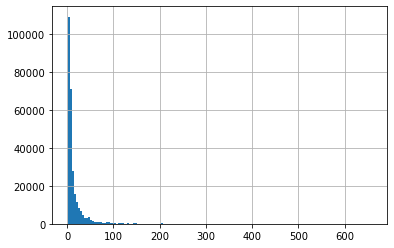

In [567]:
df_modeling_combined_selected['ps_pm25_tpy_top_5'].hist(bins=150)

<AxesSubplot:>

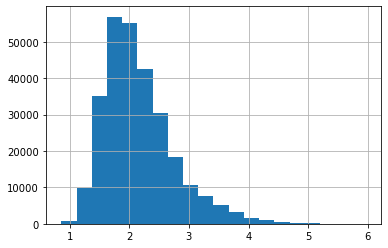

In [570]:
df_modeling_combined_selected['avg_wspd_top_5'].hist(bins=20)

<AxesSubplot:>

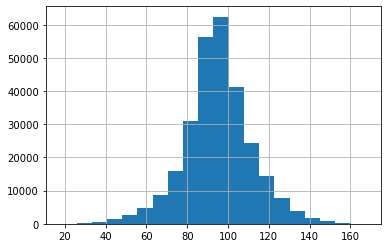

In [572]:
df_modeling_combined_selected['central_wind_alignment_180_high'].hist(bins=20)

<AxesSubplot:>

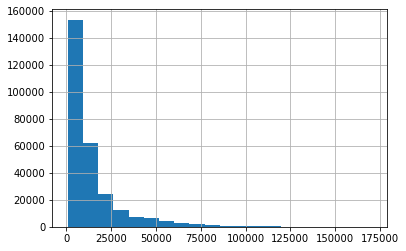

In [573]:
df_modeling_combined_selected['school_to_ps_geod_dist_m_top_5'].hist(bins=20)

<AxesSubplot:>

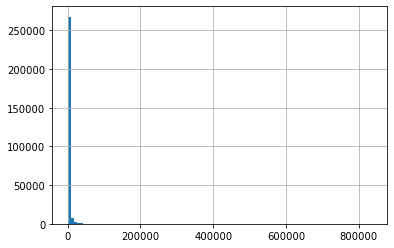

In [583]:
df_modeling_combined_selected['Izmy_v1_unnormed'].hist(bins=100)

<AxesSubplot:>

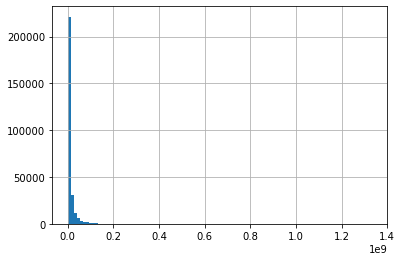

In [584]:
df_modeling_combined_selected['Izmy_v2_nodist_unnormed'].hist(bins=100)

<AxesSubplot:>

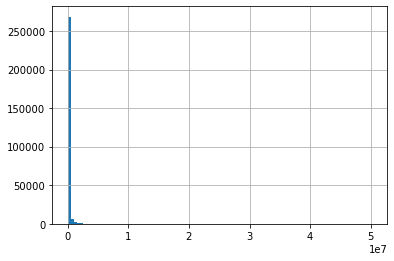

In [586]:
df_modeling_combined_selected['Izmy_v3_normed_D_and_TPY'].hist(bins=100)

<AxesSubplot:>

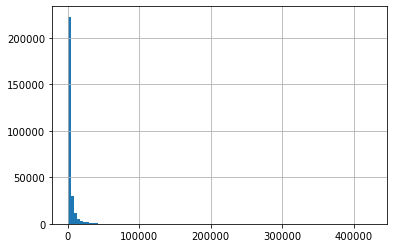

In [587]:
df_modeling_combined_selected['Izmy_v4_nodist_normed_TPY'].hist(bins=100)

<AxesSubplot:>

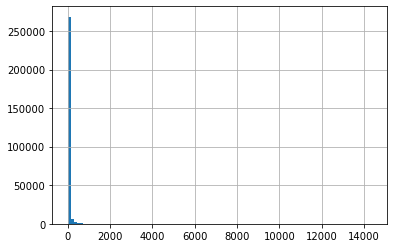

In [588]:
df_modeling_combined_selected['Izmy_v5_all_normed'].hist(bins=100)